# Interrupted Time Series for fixed-period interventions

Interrupted time series experiments could be broken down into two types.

1. Interventions that occur at a point in time
2. Interventions that have a fixed period.

This notebook deals with the latter case, where there is no intervention up to a point where an intervention is in effect for a fixed period of time. Examples might include marketing promotions, price discounts, or public policy interventions.

When we are dealing with fixed-period interventions, we can make our interrupted time series experiment aware of this by providing `treatment_end_time` as a keyword argument. This then creates 3 distinct time periods: 

- **Pre-intervention perior:** Before any treatment has taken effect. This is what we fit our model to.
- **Intervention period**: When treatment is active (from `treatment_time` to `treatment_end_time`)
- **Post-intervention period**: After treatment ends

This enables analysis of immediate effects, effect persistence, and decay patterns.

:::{note}
For standard two-period ITS analysis (permanent interventions), see {doc}`its_pymc`.
:::


In [1]:
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Example: Marketing Campaign

We simulate a 12-week marketing campaign with an immediate effect (+25 units) and partial persistence after it ends (+8 units, ~30% persistence).


In [3]:
# Set up simulation parameters
rng = np.random.default_rng(seed)
n_weeks = 135  # 2 years of weekly data
dates = pd.date_range(start="2022-06-01", end="2024-12-31", freq="W")

# Baseline: trend + seasonality + noise
trend = np.linspace(100, 120, n_weeks)
season = 10 * np.sin(2 * np.pi * np.arange(n_weeks) / 52)  # Annual seasonality
noise = rng.normal(0, 5, n_weeks)
baseline = trend + season + noise

# Add intervention effect
treatment_idx = n_weeks // 2  # Start at midpoint
treatment_end_idx = treatment_idx + 12  # 12 weeks duration

y = baseline.copy()
y[treatment_idx:treatment_end_idx] += 25  # During intervention
y[treatment_end_idx:] += 8  # Post-intervention (persistence)

# Create DataFrame
df = pd.DataFrame(
    {
        "y": y,
        "t": np.arange(n_weeks),
        "month": dates.month,
    },
    index=dates,
)

treatment_time = dates[treatment_idx]
treatment_end_time = dates[treatment_end_idx]

print(f"Treatment starts: {treatment_time}")
print(f"Treatment ends: {treatment_end_time}")
print(f"Intervention period: {treatment_end_idx - treatment_idx} weeks")
print(f"Post-intervention period: {n_weeks - treatment_end_idx} weeks")

Treatment starts: 2023-09-17 00:00:00
Treatment ends: 2023-12-10 00:00:00
Intervention period: 12 weeks
Post-intervention period: 56 weeks


Let's first visualize the raw time series data to get an intuitive sense of the intervention effect

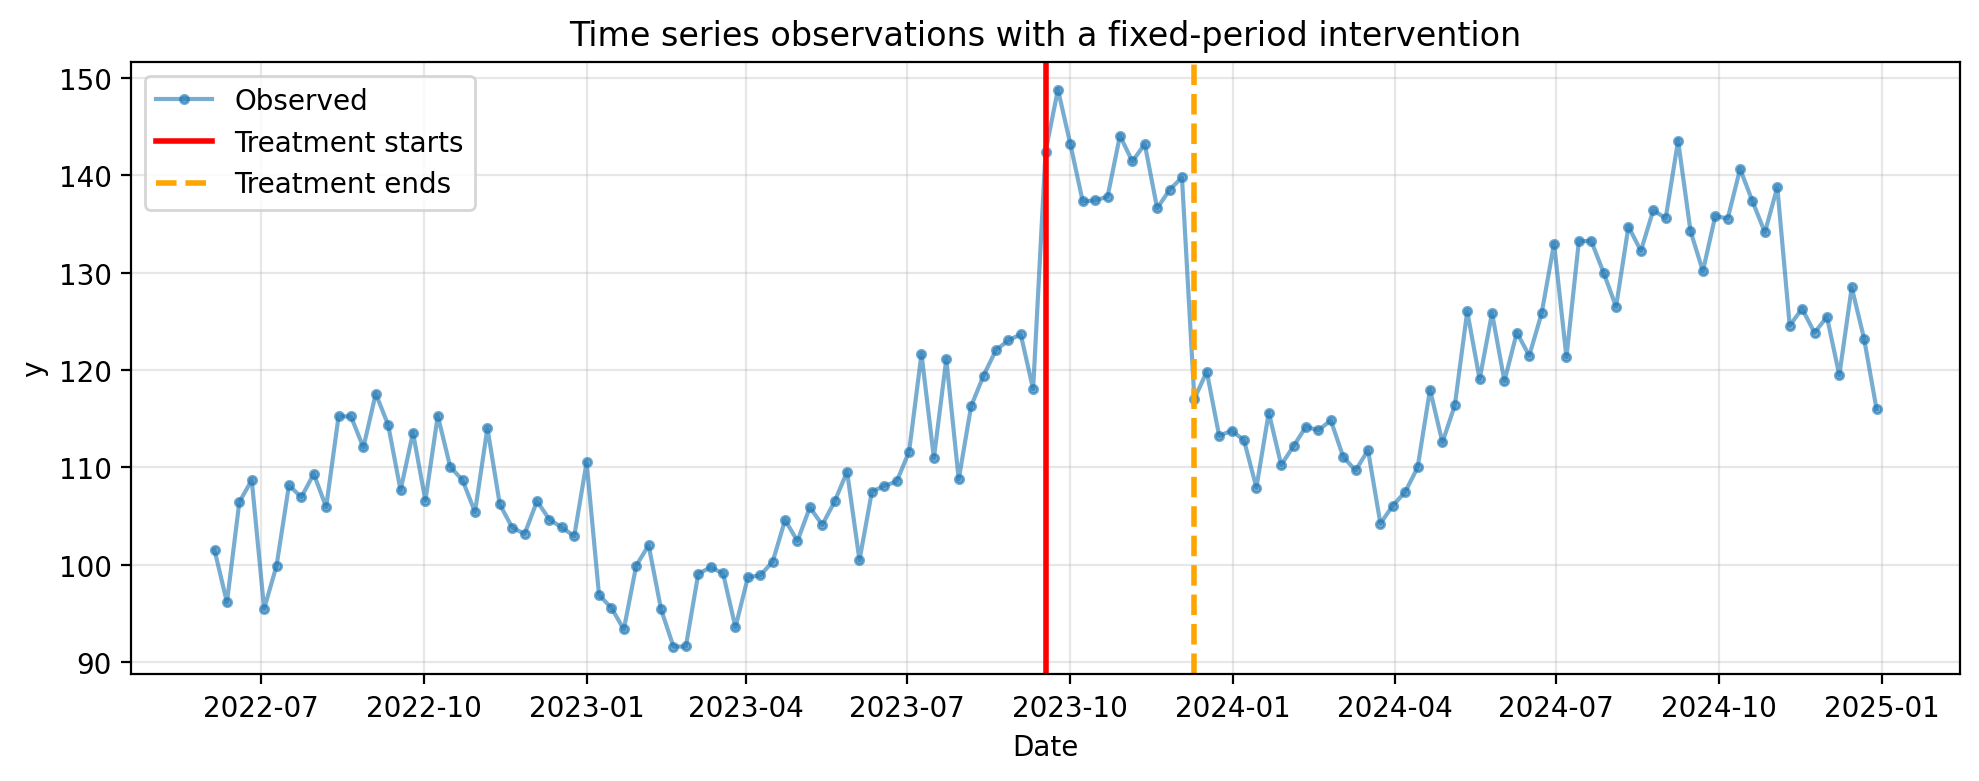

In [4]:
# Plot the raw data with treatment periods marked
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df.index, df["y"], "o-", markersize=3, alpha=0.6, label="Observed")
ax.axvline(
    treatment_time, color="red", linestyle="-", linewidth=2, label="Treatment starts"
)
ax.axvline(
    treatment_end_time,
    color="orange",
    linestyle="--",
    linewidth=2,
    label="Treatment ends",
)

ax.set_xlabel("Date")
ax.set_ylabel("y")
ax.set_title("Time series observations with a fixed-period intervention")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Run the Analysis

Specify `treatment_end_time` to enable three-period analysis:


In [5]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time=treatment_time,
    treatment_end_time=treatment_end_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "random_seed": seed,
            "progressbar": False,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


## Visualization

The three-period design visualization adds a vertical line to mark where the treatment ends:

- **Solid red line**: `treatment_time` (intervention start)
- **Dashed orange line**: `treatment_end_time` (intervention end)

The plot shows three panels:
1. **Top panel**: Time series with observations, counterfactual predictions, and causal impact shading
2. **Middle panel**: Pointwise causal impact over time
3. **Bottom panel**: Cumulative causal impact

The vertical line at `treatment_end_time` clearly separates the intervention period from the post-intervention period, allowing you to visually assess effect persistence and decay.


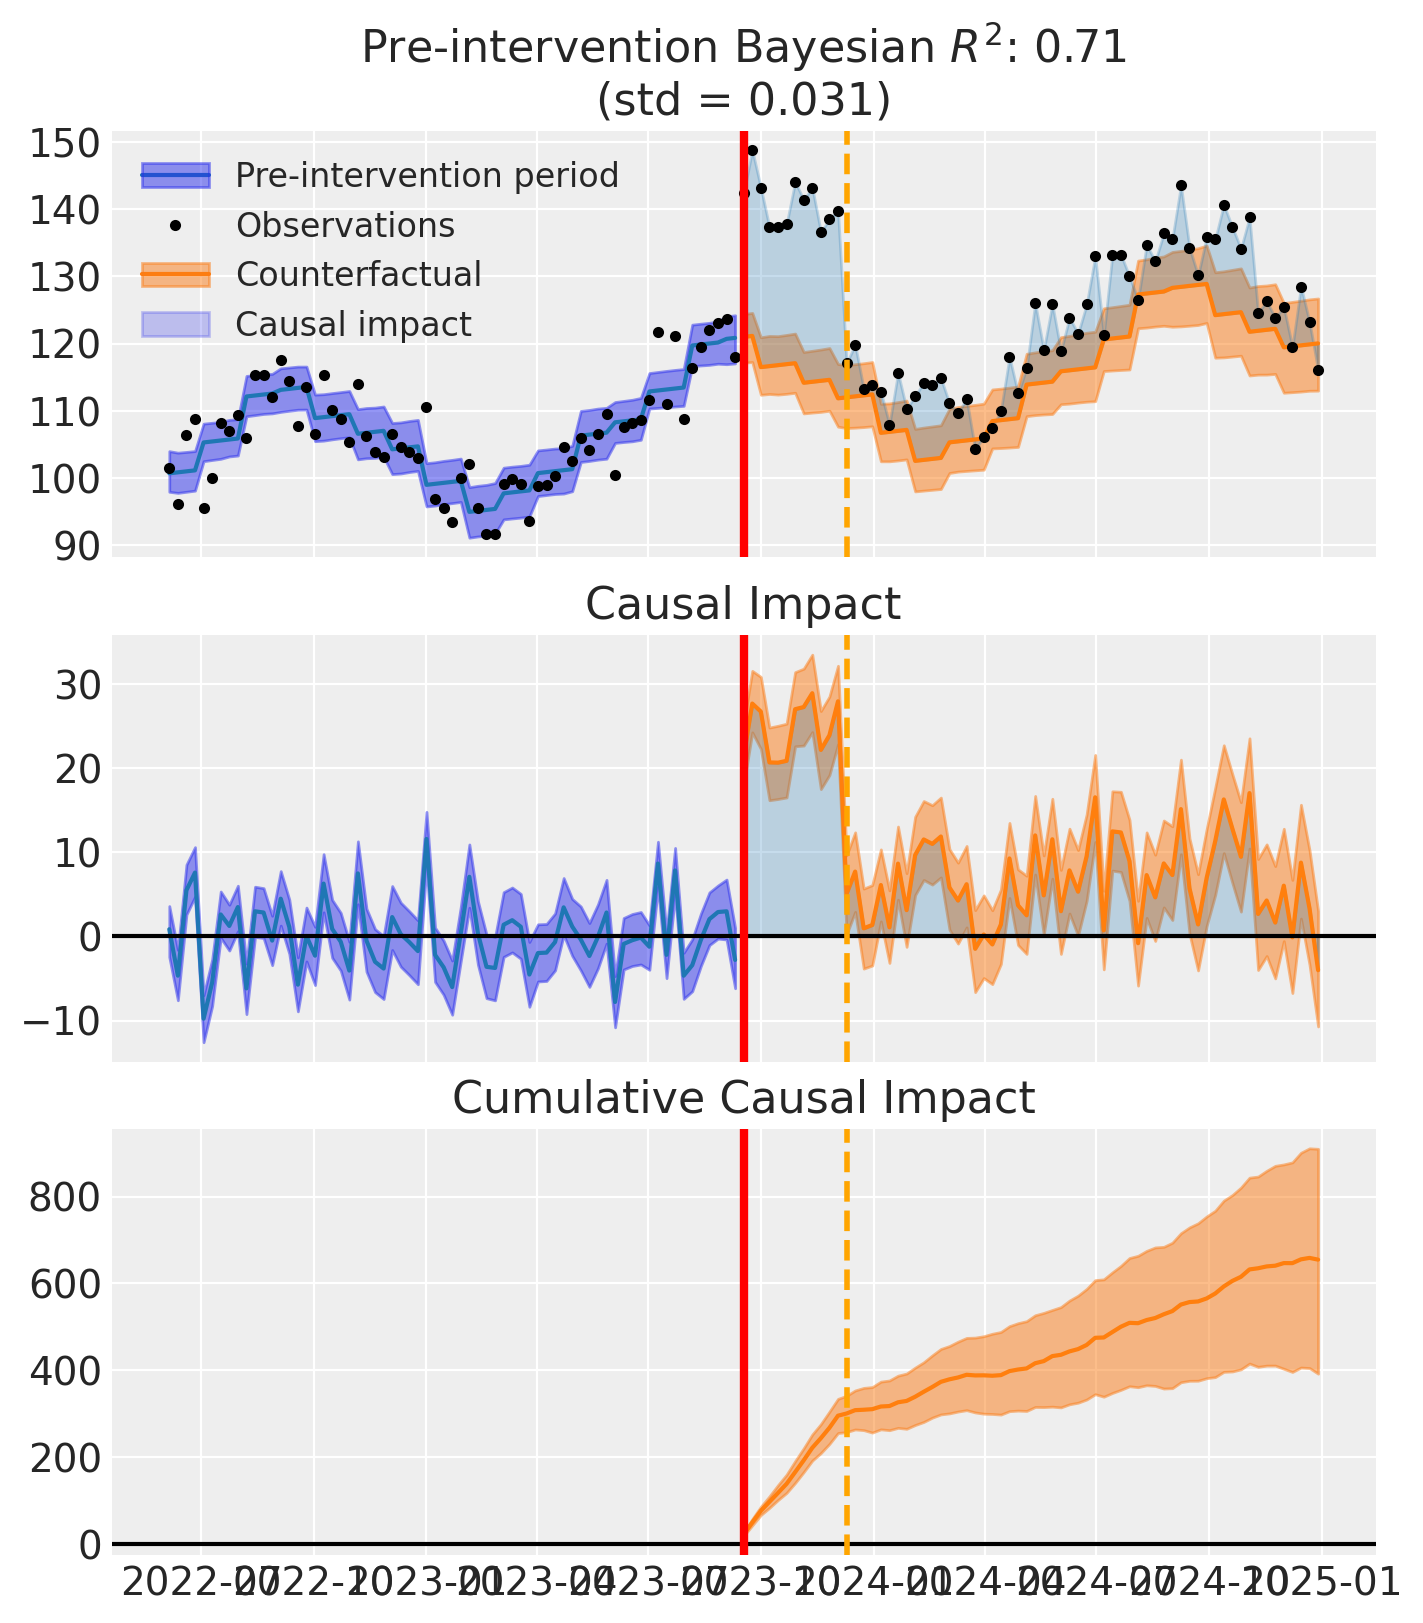

In [6]:
fig, ax = result.plot()
plt.show()

## Period-Specific Summaries

Get separate summaries for each period using the `period` parameter:


In [7]:
# Intervention period
intervention_summary = result.effect_summary(period="intervention")

wrapped = textwrap.fill(intervention_summary.text, width=75)
print(wrapped)

During intervention (2023-09-17 00:00:00 to 2023-12-03 00:00:00), the
average effect was 24.59 (95% HDI [21.13, 27.97]), with a posterior
probability of an increase of 1.000. The cumulative effect was 295.05 (95%
HDI [253.59, 335.62]); probability of an increase 1.000. Relative to the
counterfactual, this equals 21.17% on average (95% HDI [17.47%, 24.59%]).


In [8]:
# Post-intervention period
post_summary = result.effect_summary(period="post")
wrapped = textwrap.fill(post_summary.text, width=75)
print(wrapped)

Post-intervention (2023-12-10 00:00:00 to 2024-12-29 00:00:00), the average
effect was 6.42 (95% HDI [2.19, 10.52]), with a posterior probability of an
increase of 0.999. The cumulative effect was 359.61 (95% HDI [122.42,
589.00]); probability of an increase 0.999. Relative to the counterfactual,
this equals 5.56% on average (95% HDI [1.82%, 9.38%]).


## Comparison Summary

Use `period='comparison'` to get a comparative summary showing persistence metrics:


In [9]:
comparison_summary = result.effect_summary(period="comparison")
wrapped = textwrap.fill(comparison_summary.text, width=75)
print(wrapped)

Effect persistence: The post-intervention effect (6.4, 95% HDI [2.2, 10.5])
was 26.1% of the intervention effect (24.6, 95% HDI [21.1, 28.0]), with a
posterior probability of 1.00 that some effect persisted beyond the
intervention period.


The comparison summary provides:
- Post-intervention effect as percentage of intervention effect
- Posterior probability that some effect persisted
- HDI interval comparison between periods


## Detailed Persistence Analysis

The `analyze_persistence()` method automatically prints and returns a detailed summary of effect persistence:


In [10]:
persistence = result.analyze_persistence()

Effect Persistence Analysis

During intervention period:
  Mean effect: 24.59
  95% HDI: [21.13, 27.97]
  Total effect: 295.05

Post-intervention period:
  Mean effect: 6.42
  95% HDI: [2.19, 10.52]
  Total effect: 359.61

Persistence ratio: 0.261
  (26.1% of intervention effect persisted)


In [11]:
# Access the returned dictionary:
print("\nAccessing results programmatically:")
print(f"  Mean effect during: {persistence['mean_effect_during']:.2f}")
print(f"  Mean effect post: {persistence['mean_effect_post']:.2f}")
print(
    f"  Persistence ratio: {persistence['persistence_ratio']:.3f} ({persistence['persistence_ratio'] * 100:.1f}%)"
)
print(f"  Total effect during: {persistence['total_effect_during']:.2f}")
print(f"  Total effect post: {persistence['total_effect_post']:.2f}")


Accessing results programmatically:
  Mean effect during: 24.59
  Mean effect post: 6.42
  Persistence ratio: 0.261 (26.1%)
  Total effect during: 295.05
  Total effect post: 359.61


## Summary

The three-period design enables analysis of temporary interventions:

- **Immediate effects**: `effect_summary(period="intervention")` analyzes effects during the active intervention
- **Persistence**: `effect_summary(period="post")` measures how effects persist after the intervention ends
- **Comparison**: `effect_summary(period="comparison")` provides a comparative summary with persistence metrics
- **Detailed analysis**: `analyze_persistence()` automatically prints and returns a detailed summary with mean effects, persistence ratio (as decimal), and total effects

The persistence ratio (e.g., 0.30 = 30%) indicates how much of the intervention effect "carried over" into the post-intervention period. Note that the ratio can exceed 1.0 if the post-intervention effect is larger than the intervention effect.

In practice, persistence effects could be caused by various mechanisms. For example, in marketing contexts, persistence might reflect brand awareness effects that continue to influence consumer behavior even after the promotional campaign ends.
